# Example 16 Plot S2 absorption spectrum of pyrazine

References
* [Raab, A., Worth, G. A., Meyer, H.-D., and Cederbaum, L. S. “Molecular dynamics of pyrazine after excitation to the $S_2$ electronic state using a realistic 24-mode model Hamiltonian.” *The Journal of Chemical Physics* 110.19 (1999).](https://pubs.aip.org/aip/jcp/article-abstract/110/2/936/475747 )
* [Yamazaki, I., Murao, T., Yamanaka, T., and Yoshihara, K. “Intramolecular Electronic Relaxation and Photoisomerization Processes in the Isolated Azabenzene Molecules Pyridine, Pyrazine and Pyrimidine.” *Faraday Discussions of the Chemical Society* 75 (1983).](https://doi.org/10.1063/1.466618 )

## Model Hamiltonian
The parameters in the Hamiltonian are given in **electron volts (eV)** while, in the calculation, these values were converted to **atomic units (a.u.)** .
This model contains two excited states (S1 and S2).

$$
\begin{align}
&\text{H}=\text{H}_{\text{el}}+\text{H}_{\text{vib}}+\text{H}_{G_{1}}+\text{H}_{G_{2}}+\text{H}_{G_{3}}+\text{H}_{G_{4}} 
,
\\
&\text{H}_{\text{el}}=\begin{pmatrix} -0.4230 & 0 \\ 0 & 0.4230 \end{pmatrix} 
, 
\\
&\text{H}_{\text{vib}}=\sum_{i\in \{6a,1,9a...,16b,11\}}\frac{\omega_{i}}{2}(P_{i}^{2}+Q_{i}^{2}) 
, 
\\
&\text{H}_{G_{1}}= 
\begin{pmatrix} -0.0981 & 0 \\ 0 & 0.1355 \end{pmatrix}Q_{6a} 
+ \begin{pmatrix} -0.0503 & 0 \\ 0 & -0.1710 \end{pmatrix}Q_{1} 
+ \begin{pmatrix} 0.1452 & 0 \\ 0 & 0.0375 \end{pmatrix}Q_{9a} 
+ \begin{pmatrix} -0.0445 & 0 \\ 0 & 0.0168 \end{pmatrix}Q_{8a} 
+ \begin{pmatrix} 0.0247 & 0 \\ 0 & 0.0162 \end{pmatrix}Q_{2} 
, 
\\
&\text{H}_{G_{2}}= 
\sum_{(i,j) \in G_{2}}\underbrace{\begin{pmatrix}a_{ij} & 0 \\ 0 & b_{ij}\end{pmatrix}Q_{i}Q_{j}}_{\text{40 pairs}} 
, 
\\
&\text{H}_{G_{3}}= 
\begin{pmatrix} 0 & 0.2080 \\ 0.2080 & 0 \end{pmatrix}Q_{10a} 
, 
\\
&\text{H}_{G_{4}}= 
\sum_{(i,j) \in G_{4}}\underbrace{\begin{pmatrix}0 & c_{ij} \\ c_{ij} & 0\end{pmatrix}Q_{i}Q_{j}}_{\text{29 pairs}}
\end{align}
$$

## 1.Import modules

In [1]:
import platform
import sys

import pytdscf

print(sys.version)
print(f"pytdscf version = {pytdscf.__version__}")
print(platform.platform())

3.10.19 (main, Oct  9 2025, 15:25:03) [Clang 16.0.0 (clang-1600.0.26.6)]
pytdscf version = 1.3.0
macOS-26.1-arm64-arm-64bit


In [ ]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import sympy
from pympo import AssignManager, OpSite, SumOfProducts

from pytdscf import (
    BasInfo,
    Boson,
    Exciton,
    Model,
    Simulator,
    TensorHamiltonian,
    TensorOperator,
    units,
)

## 2.Set model parameters

In [3]:
backend = "numpy"

# (eV)
# delta, omega coeff data : taken from https://pubs.aip.org/aip/jcp/article-abstract/110/2/936/475747
delta = 0.4320

omega = [
    0.0739, 0.1258, 0.1525, 0.1961, 0.3788, # Ag (6a, 1, 9a, 8a, 2)
    0.1139,                                 # B1g (10a)
    0.0937, 0.1219,                         # B2g (4, 5)
    0.0873, 0.1669, 0.1891, 0.3769,         # B3g (6b, 3, 8b, 7b)
    0.0423, 0.1190,                         # Au (16a, 17a)
    0.1266, 0.1408, 0.1840, 0.3734,         # B1u (12, 18a, 19a, 13)
    0.1318, 0.1425, 0.1756, 0.3798,         # B2u (18b, 14, 19b, 20b)
    0.0521, 0.0973                          # B3u (16b, 11)
]

# data of G1 (eV)
# k_mode : [a_i, b_i]
g1_data = {
    0: [-0.0981,  0.1355], # 6a
    1: [-0.0503, -0.1710], # 1
    2: [ 0.1452,  0.0375], # 9a
    3: [-0.0445,  0.0168], # 8a
    4: [ 0.0247,  0.0162]  # 2
}


# data of G2 (eV)
# B1g x Ag
# except Ag x Ag
# (k_mode, l_mode) : [aij, bij]
g2_data = {
    # Au modes (v16a=omega13, v17a=omega17)
    (13, 13): [ 0.01145, -0.01459], # 16a * 16a
    (17, 17): [-0.02040, -0.00618], # 17a * 17a
    (13, 17): [ 0.00100, -0.00091], # 16a * 17a

    # B1g mode (v10a:omega5)
    (5, 5): [-0.01159, -0.01159],   # 10a * 10a

    # B2g modes (v4:omega6, v5:omega11)
    (6, 6): [-0.02252, -0.03445],   # 4 * 4
    (11, 11): [-0.01825, -0.00265], # 5 * 5
    (6, 11): [-0.00049,  0.00911],  # 4 * 5

    # B3g modes (v6b:omega7, v3:omega8, v8b:omega9, v7b:omega10)
    (7, 7): [-0.00741, -0.00385],   # 6b * 6b
    (8, 8): [ 0.05183,  0.04842],   # 3 * 3
    (9, 9): [-0.05733, -0.06332],   # 8b * 8b
    (10, 10): [-0.00333, -0.00040], # 7b * 7b
    (7, 8): [ 0.01321, -0.00661],   # 6b * 3
    (7, 9): [-0.00717,  0.00429],   # 6b * 8b
    (7, 10): [ 0.00515, -0.00246],  # 6b * 7b
    (8, 9): [-0.03942, -0.03034],   # 3 * 8b
    (8, 10): [ 0.00170, -0.00185],  # 3 * 7b
    (9, 10): [-0.00204, -0.00388],  # 8b * 7b

    # B1u modes (v12:omega12, v18a:omega14, v19a:omega15, v13:omega16)
    (12, 12): [-0.04819, -0.00840], # 12 * 12
    (14, 14): [-0.00792,  0.00429], # 18a * 18a
    (15, 15): [-0.02429, -0.00734], # 19a * 19a
    (16, 16): [-0.00492,  0.00346], # 13 * 13
    (12, 14): [ 0.00525,  0.00536], # 12 * 18a
    (12, 15): [-0.00485, -0.00097], # 12 * 19a
    (12, 16): [-0.00326,  0.00034], # 12 * 13
    (14, 15): [ 0.00852,  0.00209], # 18a * 19a
    (14, 16): [ 0.00888, -0.00049], # 18a * 13
    (15, 16): [-0.00443,  0.00346], # 19a * 13

    # B2u modes (v18b:omega18, v14:omega20, v19b:omega21, v20b:omega22)
    (18, 18): [-0.00277, -0.01179], # 18b * 18b
    (20, 20): [ 0.03924,  0.04000], # 14 * 14
    (21, 21): [ 0.00992,  0.01246], # 19b * 19b
    (22, 22): [-0.00110,  0.00069], # 20b * 20b
    (18, 20): [ 0.00016, -0.00844], # 18b * 14
    (18, 21): [-0.00250,  0.07000], # 18b * 19b
    (18, 22): [ 0.00357, -0.01249], # 18b * 20b
    (20, 21): [-0.00197, -0.05000], # 14 * 19b
    (20, 22): [-0.00355,  0.00265], # 14 * 20b
    (21, 22): [ 0.00623, -0.00422], # 19b * 20b

    # B3u modes (v16b:omega19, v11:omega23)
    (19, 19): [-0.02176, -0.02214], # 16b * 16b
    (23, 23): [ 0.00315, -0.00496], # 11 * 11
    (19, 23): [-0.00624, -0.00261], # 16b * 11
}

# data of G3 (eV)
# mode 10a(omega5) : c_i
g3_val = 0.2080

# data of G4 (eV)
# (k_mode, l_mode) : c_ij
# v6a:omega0, v1:omega1, v9a:omega2, v8a:omega3, v2:omega4, v10a:omega5,
# v4:omega6, v6b:omega7, v3:omega8, v8b:omega9, v7b:omega10, v5:omega11,
# v12:omega12, v16a:omega13, v18a:omega14, v19a:omega15, v13:omega16, v17a:omega17,
# v18b:omega18, v16b:omega19, v14:omega20, v19b:omega21, v20b:omega22, v11:omega23

g4_data = {
    # B1g x Ag
    (5, 0): -0.01000,  # 10a * 6a
    (5, 1): -0.00551,  # 10a * 1
    (5, 2):  0.00127,  # 10a * 9a
    (5, 3):  0.00799,  # 10a * 8a
    (5, 4): -0.00512,  # 10a * 2

    # B2g x B3g
    (6, 7): -0.01372,  # 4 * 6b
    (6, 8): -0.00466,  # 4 * 3
    (6, 9):  0.00329,  # 4 * 8b
    (6, 10):-0.00031,  # 4 * 7b
    (11, 7): 0.00598,  # 5 * 6b
    (11, 8):-0.00914,  # 5 * 3
    (11, 9): 0.00961,  # 5 * 8b
    (11, 10): 0.00500, # 5 * 7b

    # Au x B1u
    (13, 12): -0.01056, # 16a * 12
    (13, 14):  0.00559, # 16a * 18a
    (13, 15):  0.00401, # 16a * 19a
    (13, 16): -0.00226, # 16a * 13
    (17, 12): -0.01200, # 17a * 12
    (17, 14): -0.00213, # 17a * 18a
    (17, 15):  0.00328, # 17a * 19a
    (17, 16): -0.00396, # 17a * 13

    # B3u x B2u
    (19, 18):  0.00118, # 16b * 18b
    (19, 20): -0.00009, # 16b * 14
    (19, 21): -0.00285, # 16b * 19b
    (19, 22): -0.00095, # 16b * 20b
    (23, 18):  0.01281, # 11 * 18b
    (23, 20): -0.01780, # 11 * 14
    (23, 21):  0.00134, # 11 * 19b
    (23, 22): -0.00481  # 11 * 20b
}


In [4]:
delta_sym = delta/ units.au_in_eV

omega_syms = [sympy.Symbol(f"omega_{i}") for i in range(len(omega))]

subs = {}
for omega_val, omega_sym in zip(
    omega, omega_syms, strict=True
):
    subs[omega_sym] = omega_val / units.au_in_eV


## 3.Setup basis for wavefunction

In [ ]:
nmode = len(omega)
nsite = (nmode + 1)
basis = []
for isite in range(nsite):
    if isite == 0:
        basis.append(Exciton(nstate=2))
    else:
        basis.append(Boson(nstate=10))
basinfo = BasInfo([basis])

## 4.Setup operator

In [ ]:
p = basis[1].get_p_matrix()
q = basis[1].get_q_matrix()
pp = basis[1].get_p2_matrix()
qq = basis[1].get_q2_matrix()

In [ ]:
q_ops = []
p_ops = []
qq_ops = []
pp_ops = []

for isite in range(nsite):
    if isite == 0:
        q_ops.append(None)
        p_ops.append(None)
        qq_ops.append(None)
        pp_ops.append(None)

    else:
        q_ops.append(OpSite("Q_{" + f"{isite}" + "}", isite, value=q))
        p_ops.append(OpSite("P_{" + f"{isite}" + "}", isite, value=p))
        qq_ops.append(OpSite("Q2_{" + f"{isite}" + "}", isite, value=qq))
        pp_ops.append(OpSite("P2_{" + f"{isite}" + "}", isite, value=pp))


In [8]:
sop = SumOfProducts()

# H_el
el_mat = np.zeros((2, 2), dtype=np.float64)
el_mat[0,0]= -delta_sym
el_mat[1,1]= delta_sym
sop += OpSite("H_el", 0, value=el_mat)

# (eV) -> (au)
ev_to_au = 1.0 / units.au_in_eV

for k_mode in range(nmode):
    jsite = 1 + k_mode

    # H_vib
    sop += 0.5*omega_syms[k_mode] * (pp_ops[jsite] + qq_ops[jsite])

    # H_G1
    if k_mode in g1_data:
        coeffs = g1_data[k_mode]
        mat_g1 = np.diag(coeffs) * ev_to_au
        sop += OpSite(f"V_G1_{k_mode}", 0, value=mat_g1) * q_ops[jsite]

    # H_G3
    elif k_mode == 5: # index 5 = 10a
        mat_g3 = np.array([[0.0,    g3_val],[g3_val, 0.0]]) * ev_to_au
        sop += OpSite(f"V_G3_{k_mode}", 0, value=mat_g3) * q_ops[jsite]


# H_G3
for (k_mode, l_mode), coeff in g2_data.items():
    j_1site = k_mode + 1
    j_2site = l_mode + 1
    mat_g2_current = np.diag(coeff) * ev_to_au
    sop += OpSite(f"V_G2_{k_mode}_{l_mode}", 0, value=mat_g2_current) * q_ops[j_1site] * q_ops[j_2site]


# H_G4
for (k_mode, l_mode), coeff in g4_data.items():
    j_1site = k_mode + 1
    j_2site = l_mode + 1
    mat_g4 = np.array([[0.0, 1.0], [1.0, 0.0]]) * (coeff * ev_to_au)
    sop += OpSite(f"V_G4_{k_mode}_{l_mode}", 0, value=mat_g4) * q_ops[j_1site] * q_ops[j_2site]


sop = sop.simplify()

## 5.Setup MPO

In [9]:
am_pot = AssignManager(sop)
_ = am_pot.assign()
pot_mpo = am_pot.numerical_mpo(subs=subs)

## 6.Setup Hamiltonian

In [ ]:
potential = [
    [{tuple((k, k) for k in range(nsite)): TensorOperator(mpo=pot_mpo)}]
]
H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=None, backend=backend
)
operators = {"hamiltonian": H}

## 7.Setup initial states

In [ ]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = 20


S2_state = [0.0, 1.0]


nprim_boson = basis[1].nprim if len(basis) > 1 else 10
boson_site = [1.0] + [0.0] * (nprim_boson - 1)


initial_weights = []
for isite in range(nsite):
    if isite == 0:
        initial_weights.append(S2_state)
    else:
        initial_weights.append(boson_site)

model.init_HartreeProduct = [initial_weights]

inital state : S2


## 8.Execution

In [13]:
jobname = "pyrazine"
simulator = Simulator(jobname=jobname, model=model, backend=backend, verbose=2)
simulator.propagate(
    maxstep=1500,
    stepsize=0.1,
    reduced_density=(
        [(0, 0)],
        10,
    ),
    energy=True,
    autocorr=True,
    observables=False,
    observables_per_step=10
)

17:52:36 | INFO | Log file is ./pyrazine_prop/main.log
17:52:36 | INFO | Wave function is saved in wf_pyrazine.pkl
17:52:36 | INFO | The time unit in the netCDF file is fs
17:52:36 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/1500 [00:00<?, ?it/s]

17:52:38 | INFO | End     0 step; propagated    0.100 [fs]; AVG Krylov iteration: 6.76
17:54:56 | INFO | End   100 step; propagated   10.100 [fs]; AVG Krylov iteration: 6.76
17:57:09 | INFO | End   200 step; propagated   20.100 [fs]; AVG Krylov iteration: 6.76
17:59:23 | INFO | End   300 step; propagated   30.100 [fs]; AVG Krylov iteration: 6.96
18:01:37 | INFO | End   400 step; propagated   40.100 [fs]; AVG Krylov iteration: 6.96
18:03:57 | INFO | End   500 step; propagated   50.100 [fs]; AVG Krylov iteration: 6.96
18:06:21 | INFO | End   600 step; propagated   60.100 [fs]; AVG Krylov iteration: 6.96
18:08:42 | INFO | End   700 step; propagated   70.100 [fs]; AVG Krylov iteration: 6.96
18:11:06 | INFO | End   800 step; propagated   80.100 [fs]; AVG Krylov iteration: 6.96
18:13:27 | INFO | End   900 step; propagated   90.100 [fs]; AVG Krylov iteration: 6.96
18:15:49 | INFO | Saved wavefunction   99.900 [fs]
18:15:52 | INFO | End  1000 step; propagated  100.100 [fs]; AVG Krylov iteratio

(0.0886331885248308, <pytdscf.wavefunction.WFunc at 0x11b5c6290>)

## 9.Plot (population,absorption spectrum)

In [ ]:
with nc.Dataset("pyrazine_prop/reduced_density.nc", "r") as file:
    density_data_real = file.variables[f"rho_({0}, {0})_0"][:][
        "real"
    ]
    density_data_imag = file.variables[f"rho_({0}, {0})_0"][:][
        "imag"
    ]
    time_data = file.variables["time"][:]

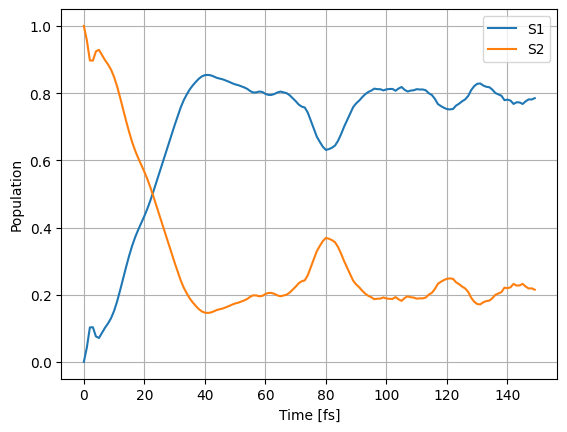

In [17]:
plt.ylabel("Population")
plt.xlabel("Time [fs]")
plt.plot(time_data, density_data_real[:, 0, 0], label="S1")
plt.plot(time_data, density_data_real[:, 1, 1 ], label="S2")
plt.grid()
plt.legend()
plt.show()

delta_t:  0.100[fs], max_freq: 333564.1[cm-1]


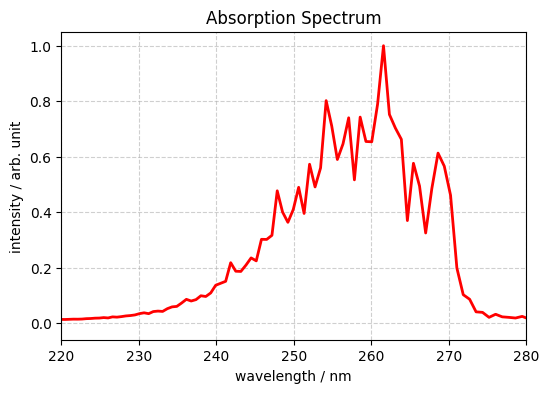

In [ ]:
# omega : taken from https://pubs.aip.org/aip/jcp/article-abstract/110/2/936/475747
omega = [
    0.0739, 0.1258, 0.1525, 0.1961, 0.3788, # Ag (6a, 1, 9a, 8a, 2)
    0.1139,                                 # B1g (10a)
    0.0937, 0.1219,                         # B2g (4, 5)
    0.0873, 0.1669, 0.1891, 0.3769,         # B3g (6b, 3, 8b, 7b)
    0.0423, 0.1190,                         # Au (16a, 17a)
    0.1266, 0.1408, 0.1840, 0.3734,         # B1u (12, 18a, 19a, 13)
    0.1318, 0.1425, 0.1756, 0.3798,         # B2u (18b, 14, 19b, 20b)
    0.0521, 0.0973                          # B3u (16b, 11)
]

E_0 = 0.5*sum(omega)-(3.94+4.89)/2 #experimental data (eV) : taken from https://doi.org/10.1063/1.466618
time, autocorr = pytdscf.spectra.load_autocorr(
    "pyrazine_prop/autocorr.dat"
)

def h(t,tau = 150):
    return np.exp(-np.abs(t)/tau)

freq, intensity = pytdscf.spectra.ifft_autocorr(time, autocorr * h(time), E_shift=E_0,window="cos")

# (cm^-1) -> (nm)
mask = freq > 0
wavelength_nm = 1e7 / freq[mask]
intensity_masked = intensity[mask]

plt.figure(figsize=(6, 4))
plt.plot(wavelength_nm, intensity_masked/ np.max(intensity_masked), color='red', lw=2)
plt.xlabel('wavelength / nm')
plt.ylabel('intensity / arb. unit')
plt.title('Absorption Spectrum')
plt.xlim(220, 280)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()